In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Đọc hình ảnh
def load_images(image_folder):
  images = []
  labels = []
  class_names = os.listdir(image_folder)
  for label, class_name in enumerate(class_names):
    class_path = os.path.join(image_folder, class_name)
    for img_name in os.listdir(class_path):
      img_path = os.path.join(class_path, img_name)
      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      if img is not None:
        images.append(img)
        labels.append(label)
  return np.array(images), np.array(labels), class_names

In [ ]:
dataset_path = '/content/drive/My Drive/CS231/Dataset/'

train_folder = os.path.join(dataset_path, 'train')
X_train, y_train, class_names = load_images(train_folder)

test_folder = os.path.join(dataset_path, 'test')
X_test, y_test, _ = load_images(test_folder)

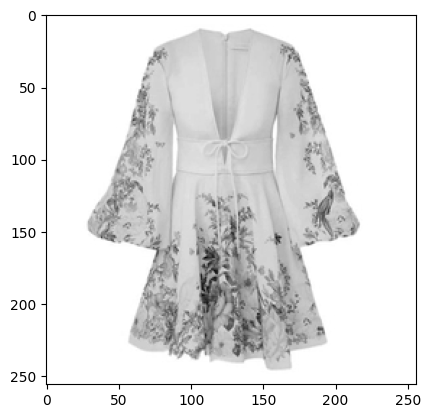

In [ ]:
plt.imshow(X_train[1], cmap='gray')

In [ ]:
def convert_to_grayscale(image):
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    return gray_image

In [ ]:
def scharr_operator(image, kernel_size=3, sigma=1.0):
    image = convert_to_grayscale(image)

    blurred = cv2.GaussianBlur(image, (kernel_size,kernel_size), sigma)

    grad_x = cv2.Scharr(blurred, cv2.CV_64F, 1, 0)
    grad_y = cv2.Scharr(blurred, cv2.CV_64F, 0, 1)

    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)

    combined_grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

    return combined_grad

In [ ]:
def extract_scharr_features(images):
    feature_list = []
    for image in images:
        features = scharr_operator(image)
        feature_list.append(features)
    return np.array(feature_list)

In [ ]:
X_train_features = extract_scharr_features(X_train)
X_test_features = extract_scharr_features(X_test)
print("Shape of X_train_features:", X_train_features.shape)
print("Shape of X_test_features:", X_test_features.shape)

Shape of X_train_features: (992, 256, 256)
Shape of X_test_features: (249, 256, 256)


In [ ]:
def flatten_features(features):
    return np.array([f.flatten() for f in features])

In [ ]:
X_train_features = flatten_features(X_train_features)
X_test_features = flatten_features(X_test_features)
print("Shape of X_train_features:",  X_train_features.shape)
print("Shape of X_test_features:", X_test_features.shape)

Shape of X_train_features: (992, 65536)
Shape of X_test_features: (249, 65536)


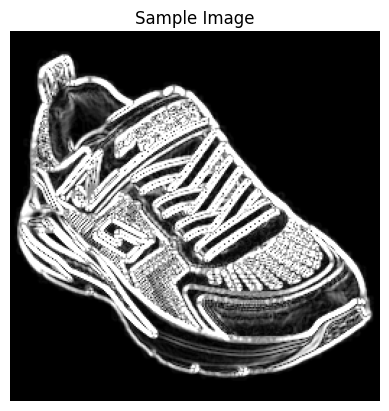

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Giả sử ảnh có kích thước gốc là 256x256
image_size = (256, 256)

# Chuyển đổi mẫu đầu tiên từ vector phẳng thành ảnh
image = X_train_features[55].reshape(image_size)

# Hiển thị ảnh
plt.imshow(image, cmap='gray')  # Sử dụng 'gray' nếu ảnh là grayscale
plt.title("Sample Image")
plt.axis('off')  # Tắt các trục
plt.show()


In [ ]:
#Hàm huấn luyện model với GridSearch
def train_model_with_gridsearch(X_train, y_train, model, param_grid):
  grid_search = GridSearchCV(
      estimator = model,
      param_grid = param_grid,
      cv=5,
      scoring='accuracy',
      n_jobs=-1)
  grid_search.fit(X_train, y_train)
  return grid_search

In [ ]:
#Hàm đánh giá và in kết quả
def evaluate_model(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=class_names)
    print("\nClassification Report:")
    print(report)
    return report

In [ ]:
#Lưu kết quả huấn luyện
def save_results(results_file, cv_results, best_params, best_score):
  with open(results_file, 'w') as f:
    for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
      line = f"Mean Accuracy: {mean_score:.6f}, Parameters: {params}"
      print(line)
      f.write(line + '\n')
    f.write(f"Best parameters: {best_params}\n")
    f.write(f"Best score: {best_score:.6f}\n")


In [ ]:
#Lưu model đã huấn luyện
def save_model(model, model_path, model_name):
    os.makedirs(model_path, exist_ok=True)
    model_file = os.path.join(model_path, model_name)
    joblib.dump(model, model_file)
    print(f"Model saved to {model_file}")
    return model_file

In [ ]:
model_path = '/content/drive/My Drive/CS231/Source_code/Scharr/Model/'
results_path = '/content/drive/My Drive/CS231/Source_code/Scharr/Result'

In [ ]:
#Huấn luyện và đánh giá KNN
knn_params = {'n_neighbors': range(1,20),
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']
              }
knn_grid = train_model_with_gridsearch(
    X_train=X_train_features,
    y_train=y_train,
    model=KNeighborsClassifier(),
    param_grid=knn_params)

os.makedirs(results_path, exist_ok=True)
results_file = os.path.join(results_path, f'result_knn.txt')
save_results(results_file, knn_grid.cv_results_, knn_grid.best_params_, knn_grid.best_score_)

print("Best parameters for KNN:", knn_grid.best_params_)
print("Best KNN score:", knn_grid.best_score_)

evaluate_model(knn_grid.best_estimator_, X_test_features, y_test, class_names)

save_model(knn_grid.best_estimator_, model_path, f'knn_model.pkl')

Mean Accuracy: 0.799416, Parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Mean Accuracy: 0.799416, Parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
Mean Accuracy: 0.798442, Parameters: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
Mean Accuracy: 0.799416, Parameters: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Mean Accuracy: 0.770189, Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Mean Accuracy: 0.775225, Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Mean Accuracy: 0.776245, Parameters: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
Mean Accuracy: 0.769184, Parameters: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
Mean Accuracy: 0.748023, Parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Mean Accuracy: 0.755083, Parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights

'/content/drive/My Drive/CS231/Source_code/Scharr/Model/knn_model.pkl'

In [ ]:
#Huấn luyện và đánh giá bằng SVM
svm_params = {
    'kernel': ['linear', 'rbf','poly'],
    'C': [ 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

svm_grid = train_model_with_gridsearch(
    X_train=X_train_features,
    y_train=y_train,
    model=SVC(random_state=42),
    param_grid=svm_params)

os.makedirs(results_path, exist_ok=True)
results_file = os.path.join(results_path, f'result_svm.txt')
save_results(results_file, svm_grid.cv_results_, svm_grid.best_params_, svm_grid.best_score_)

print("Best parameters for SVM:", svm_grid.best_params_)
print("Best SVM score:", svm_grid.best_score_)

evaluate_model(svm_grid.best_estimator_, X_test_features, y_test, class_names)

save_model(svm_grid.best_estimator_, model_path, f'svm_model.pkl')

Mean Accuracy: 0.916380, Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Mean Accuracy: 0.760109, Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Accuracy: 0.534374, Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Mean Accuracy: 0.916380, Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
Mean Accuracy: 0.175397, Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean Accuracy: 0.851896, Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
Mean Accuracy: 0.916380, Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Mean Accuracy: 0.917380, Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Accuracy: 0.793406, Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Mean Accuracy: 0.916380, Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
Mean Accuracy: 0.210746, Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean Accuracy: 0.851896, Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Mean A

'/content/drive/My Drive/CS231/Source_code/Scharr/Model/svm_model.pkl'

In [ ]:
#Huấn luyện và đánh giá cho Random Forest
rf_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    }

rf_grid = train_model_with_gridsearch(
    X_train=X_train_features,
    y_train=y_train,
    model=RandomForestClassifier(random_state=42),
    param_grid=rf_params)

os.makedirs(results_path, exist_ok=True)
results_file = os.path.join(results_path, f'result_rf.txt')
save_results(results_file, rf_grid.cv_results_, rf_grid.best_params_, rf_grid.best_score_)

print("Best parameters for RF:", rf_grid.best_params_)
print("Best RF score:", rf_grid.best_score_)

evaluate_model(rf_grid.best_estimator_, X_test_features, y_test, class_names)

save_model(rf_grid.best_estimator_, model_path, f'rf_model.pkl')

Mean Accuracy: 0.885133, Parameters: {'max_depth': None, 'n_estimators': 10}
Mean Accuracy: 0.932501, Parameters: {'max_depth': None, 'n_estimators': 50}
Mean Accuracy: 0.933501, Parameters: {'max_depth': None, 'n_estimators': 100}
Mean Accuracy: 0.881092, Parameters: {'max_depth': 10, 'n_estimators': 10}
Mean Accuracy: 0.920395, Parameters: {'max_depth': 10, 'n_estimators': 50}
Mean Accuracy: 0.933496, Parameters: {'max_depth': 10, 'n_estimators': 100}
Mean Accuracy: 0.885133, Parameters: {'max_depth': 20, 'n_estimators': 10}
Mean Accuracy: 0.932501, Parameters: {'max_depth': 20, 'n_estimators': 50}
Mean Accuracy: 0.933501, Parameters: {'max_depth': 20, 'n_estimators': 100}
Mean Accuracy: 0.885133, Parameters: {'max_depth': 30, 'n_estimators': 10}
Mean Accuracy: 0.932501, Parameters: {'max_depth': 30, 'n_estimators': 50}
Mean Accuracy: 0.933501, Parameters: {'max_depth': 30, 'n_estimators': 100}
Best parameters for RF: {'max_depth': None, 'n_estimators': 100}
Best RF score: 0.93350083

'/content/drive/My Drive/CS231/Source_code/Scharr/Model/rf_model.pkl'

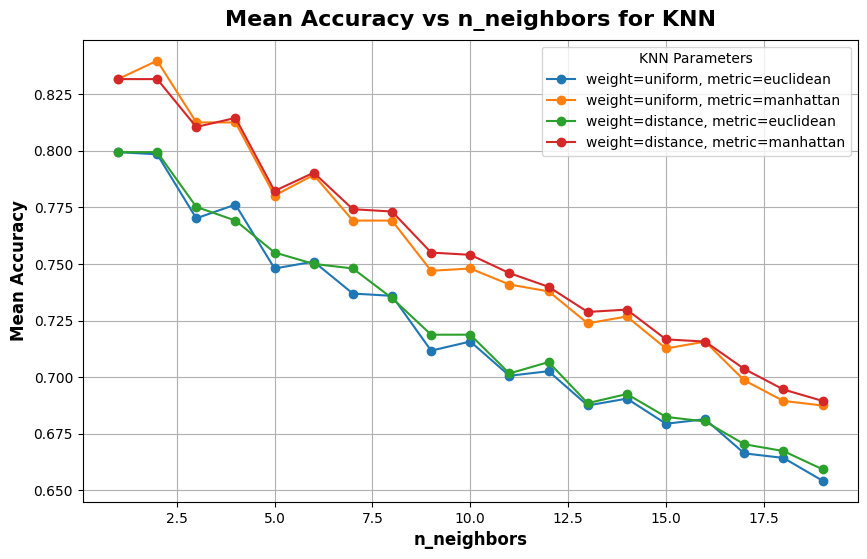

In [ ]:
def plot_knn_results(knn_grid):
    mean_accuracy = knn_grid.cv_results_['mean_test_score']
    n_neighbors = knn_grid.cv_results_['param_n_neighbors'].data
    weights = knn_grid.cv_results_['param_weights'].data
    metric = knn_grid.cv_results_['param_metric'].data

    plt.figure(figsize=(10, 6))

    for weight in ['uniform', 'distance']:
        for met in ['euclidean', 'manhattan']:
            mask = (weights == weight) & (metric == met)
            if np.any(mask):
                plt.plot(n_neighbors[mask], mean_accuracy[mask], marker='o', label=f'weight={weight}, metric={met}')

    plt.title('Mean Accuracy vs n_neighbors for KNN', fontsize=16, fontweight='bold', pad=10)
    plt.xlabel('n_neighbors', fontsize=12, fontweight='bold')
    plt.ylabel('Mean Accuracy', fontsize=12, fontweight='bold')
    plt.legend(title="KNN Parameters")
    plt.grid(True)
    plt.show()

plot_knn_results(knn_grid)

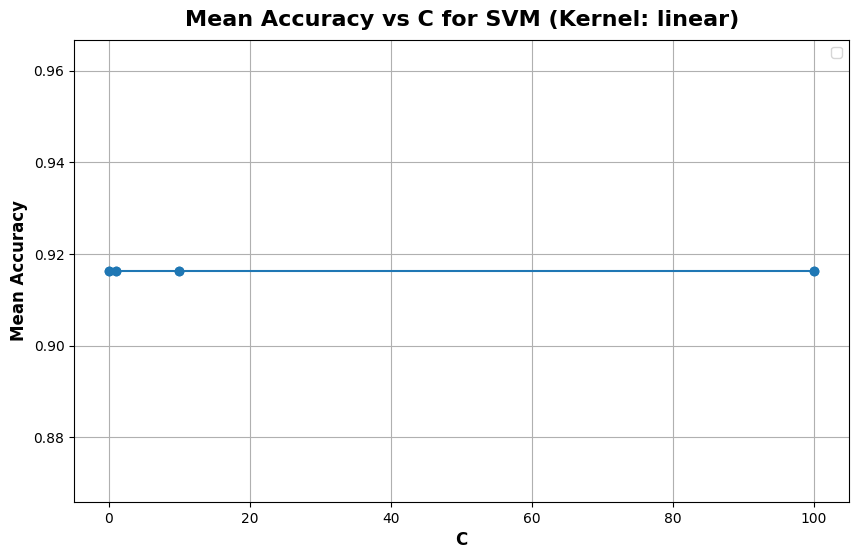

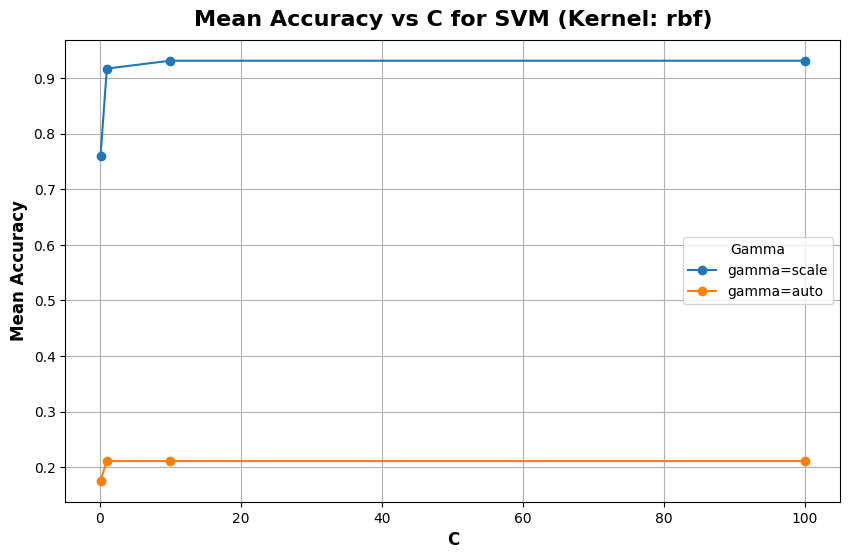

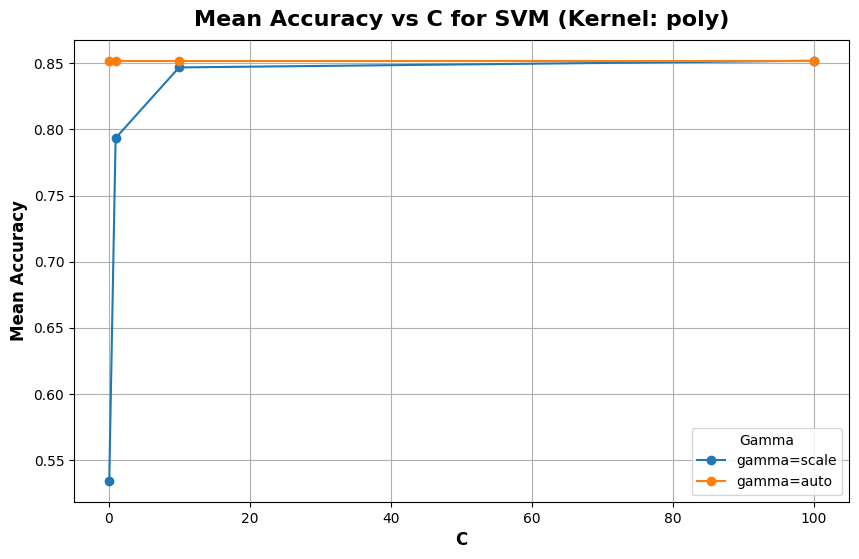

In [ ]:
def plot_svm_results(svm_grid):
    mean_accuracy = svm_grid.cv_results_['mean_test_score']
    kernel = svm_grid.cv_results_['param_kernel'].data
    C_values = svm_grid.cv_results_['param_C'].data
    gamma = svm_grid.cv_results_['param_gamma'].data

    kernels = ['linear', 'rbf', 'poly']

    for ker in kernels:
        plt.figure(figsize=(10, 6))
        if ker == 'linear':
            mask = (kernel == 'linear')
            if np.any(mask):
                plt.plot(C_values[mask], mean_accuracy[mask], marker='o')
        else:
            for gam in ['scale', 'auto']:
                mask = (kernel == ker) & (gamma == gam)
                if np.any(mask):
                    plt.plot(C_values[mask], mean_accuracy[mask], marker='o', label=f'gamma={gam}')

        plt.title(f'Mean Accuracy vs C for SVM (Kernel: {ker})', fontsize=16, fontweight='bold', pad=10)
        plt.xlabel('C', fontsize=12, fontweight='bold')
        plt.ylabel('Mean Accuracy', fontsize=12, fontweight='bold')
        plt.legend(title="Gamma" if ker != 'linear' else None)
        plt.grid(True)
        plt.show()

plot_svm_results(svm_grid)

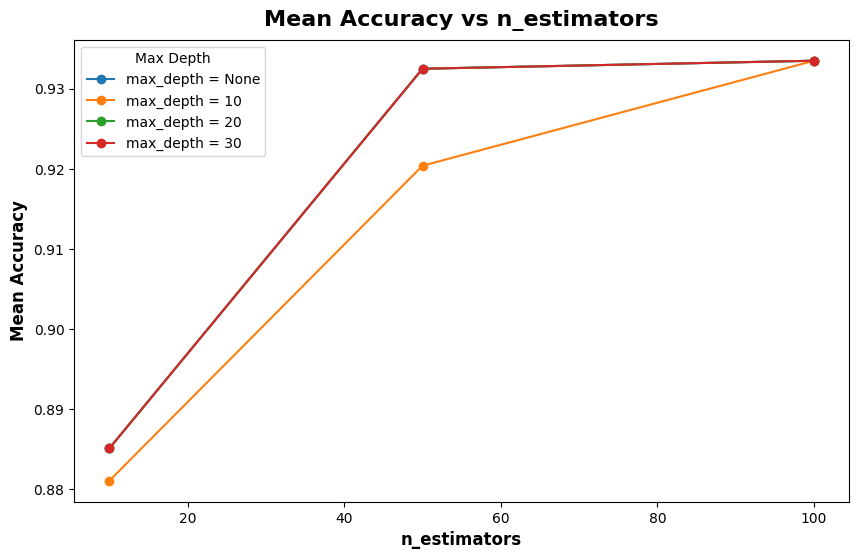

In [ ]:
# Trích xuất kết quả và tạo biểu đồ cho RF
def plot_rf():
    mean_accuracy = rf_grid.cv_results_['mean_test_score']
    n_estimators = rf_grid.cv_results_['param_n_estimators'].data
    max_depth = rf_grid.cv_results_['param_max_depth'].data

    plt.figure(figsize=(10, 6))

    mask = (max_depth == None)
    if np.any(mask):
        plt.plot(n_estimators[mask], mean_accuracy[mask], marker='o', label='max_depth = None')
    for depth in [10, 20, 30]:
        mask = (max_depth == depth)
        plt.plot(n_estimators[mask], mean_accuracy[mask], marker='o', label=f'max_depth = {depth}')

    plt.title('Mean Accuracy vs n_estimators', fontsize=16, fontweight='bold', pad=10)
    plt.xlabel('n_estimators', fontsize=12, fontweight='bold')
    plt.ylabel('Mean Accuracy', fontsize=12, fontweight='bold')
    plt.legend(title="Max Depth")
    plt.show()
plot_rf()